Introdueix el correu del client:  janesmith@gmail.com


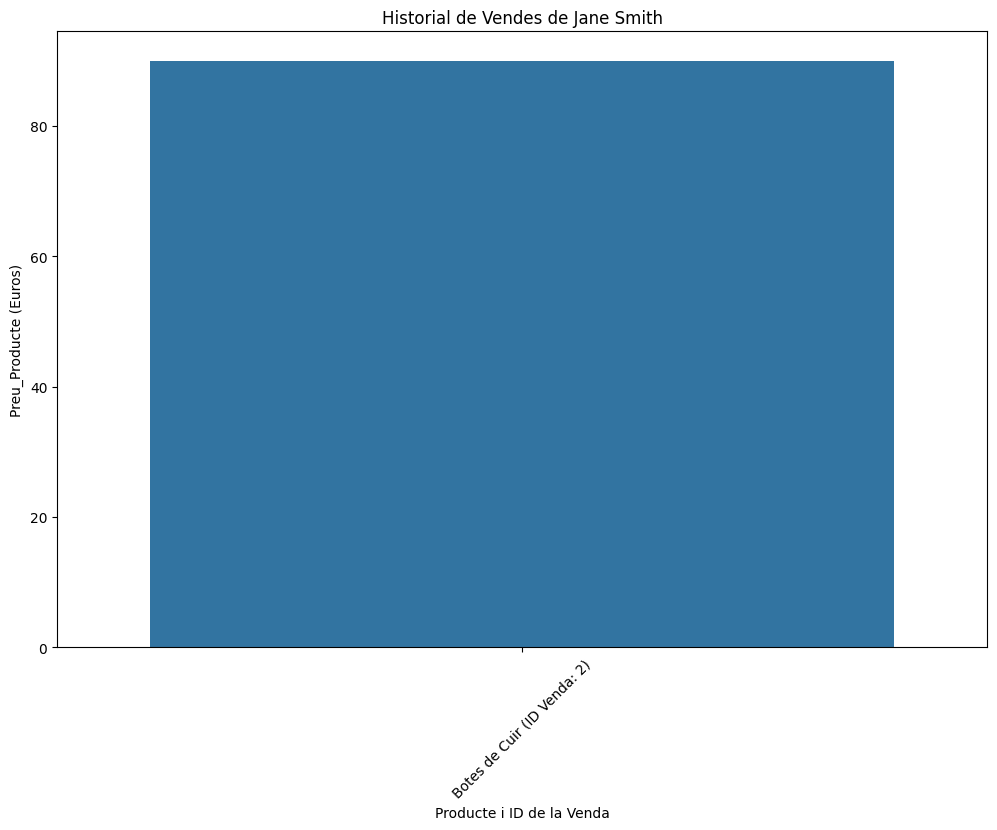

In [ ]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Acceder a la variable de entorno PYTHON_URL_BACK
PYTHON_URL_BACK = os.getenv("PYTHON_URL_BACK")

# Configurar los logs
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def visualizar_historial_ventas(correo_cliente):
    """
    Obtiene el historial de ventas de un cliente y muestra un gráfico de barras con los detalles de cada venta.
    """
    # Obtener todos los usuarios para encontrar el ID del cliente
    response = requests.get(f"{PYTHON_URL_BACK}/user")
    if response.status_code != 200:
        logging.error("Error al obtener la lista de usuarios.")
        return
    
    # Convertir la respuesta en un DataFrame y buscar el usuario por correo
    users = response.json()
    user_df = pd.DataFrame(users)
    
    cliente = user_df[user_df['email'] == correo_cliente]
    
    if cliente.empty:
        logging.warning(f"No se ha encontrado un usuario con el correo: {correo_cliente}")
        return
    
    # Obtener el nombre completo del cliente combinando 'firstName' y 'lastName'
    if 'firstName' in cliente.columns and 'lastName' in cliente.columns:
        full_name = f"{cliente['firstName'].values[0]} {cliente['lastName'].values[0]}"
    else:
        logging.warning("No se ha encontrado el nombre completo del cliente.")
        return
    
    user_id = cliente['id'].values[0]
    
    # Obtener el historial de ventas del cliente usando su ID
    response = requests.get(f"{PYTHON_URL_BACK}/ordersUser/{user_id}")
    if response.status_code != 200:
        logging.error("Error al obtener el historial de ventas del cliente.")
        return
    
    # Convertir las ventas a DataFrame
    ventas = response.json()
    
    if not ventas:
        logging.warning(f"El usuario {full_name} no ha realizado compras.")
        return
    
    # Crear una lista de descripciones de productos para cada venta
    data = []
    for venta in ventas:
        for producto in venta['orderLines']:
            data.append({
                'ID': venta['id'],  # ID de la venta
                'Clients': f"{producto['name']} (ID Venda: {venta['id']})",  # Nombre del producto con ID de la venta
                'Ventas': venta['productCount'],  # Número de productos en la venta
                'Diners': float(venta['total']),  # Total de dinero gastado
                'Diners/Venda': float(venta['total']) / venta['productCount'],  # Dinero por producto
            })
    
    # Crear un DataFrame con la información extraída
    df_ventas = pd.DataFrame(data)
    
    # Crear el gráfico de barras
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_ventas, x='Clients', y='Diners')
    
    # Añadir el título y las etiquetas con el nombre completo del cliente
    ax.set_title(f"Historial de Vendes de {full_name}")
    ax.set_xlabel("Producte i ID de la Venda")
    ax.set_ylabel("Preu_Producte (Euros)")
    plt.xticks(rotation=45)
    plt.show()

# Ejemplo de uso:
correo_cliente = input("Introdueix el correu del client: ")
visualizar_historial_ventas(correo_cliente)
